In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import pandas as pd


In [125]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [126]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
    'oldpeak', 'slope', 'ca', 'thal', 'target'
]

try:
    heart_df = pd.read_csv(url, names=columns)
    print("✅ Dataset loaded successfully!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    exit()


✅ Dataset loaded successfully!


In [127]:
# cleaning
heart_df.replace('?', np.nan, inplace=True)
for col in ['ca', 'thal']:
    heart_df[col] = pd.to_numeric(heart_df[col], errors='coerce')


heart_df.fillna(heart_df.median(), inplace=True)

In [128]:
# One-Hot Encoding for categorical variables
heart_df = pd.get_dummies(heart_df, columns=['cp', 'restecg', 'slope', 'thal', 'sex'])


feature_columns = [col for col in heart_df.columns if col != 'target']
X = heart_df[feature_columns]  # Features
y = heart_df['target'].apply(lambda x: 1 if x > 0 else 0)  # Convert to binary classification

In [129]:
#preprocessing
# Balancing the dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# class distribution after SMOTE
print("\nAfter SMOTE - Class Distribution:")
print(y_balanced.value_counts())



After SMOTE - Class Distribution:
target
0    164
1    164
Name: count, dtype: int64


In [130]:
# Splitting the Data into Training & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

In [131]:
#Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# scaler file
with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

In [132]:
#Training
# Training the XGBoost Model with Better Hyperparameters
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss"
)
xgb_model.fit(X_train_scaled, y_train)



C:\Users\stark\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:41:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [133]:
y_pred_xgb = xgb_model.predict(X_test_scaled)
print("\n🔍 XGBoost Model Performance:")
print(classification_report(y_test, y_pred_xgb))
print(f"📊 Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")


🔍 XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.85      0.88      0.87        33

    accuracy                           0.86        66
   macro avg       0.86      0.86      0.86        66
weighted avg       0.86      0.86      0.86        66

📊 Accuracy: 0.8636


In [134]:
# trained model(pickel file)
with open("heart_disease_model.pkl", "wb") as model_file:
    pickle.dump(xgb_model, model_file)

print("\n✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!


In [135]:
# Feature Importance Analysis
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": xgb_model.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

In [136]:
print("\n🔹 Top 10 Important Features:")
print(feature_importances.head(10))




🔹 Top 10 Important Features:
        Feature  Importance
11       cp_4.0    0.187867
20     thal_7.0    0.182960
7            ca    0.096690
21      sex_0.0    0.054100
16    slope_2.0    0.050805
18     thal_3.0    0.048921
22      sex_1.0    0.038099
14  restecg_2.0    0.034373
5         exang    0.031194
0           age    0.030094


In [137]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=200, verbose=0, random_state=42),
    "XgBoost" : XGBClassifier( n_estimators=200, max_depth=5, learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,eval_metric="logloss")
        
}

In [138]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "AUC": round(auc, 4) if auc else "-",
        "Precision": round(classification_report(y_test, y_pred, output_dict=True)["1"]["precision"], 4),
        "Recall": round(classification_report(y_test, y_pred, output_dict=True)["1"]["recall"], 4),
        "F1-Score": round(classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"], 4)
    })


In [139]:
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
display(results_df)


,Model,Accuracy,AUC,Precision,Recall,F1-Score
6,CatBoost,0.8788,0.9256,0.8788,0.8788,0.8788
4,Random Forest,0.8636,0.9261,0.8529,0.8788,0.8657
7,XgBoost,0.8636,0.8871,0.8529,0.8788,0.8657
0,Logistic Regression,0.8485,0.9421,0.8286,0.8788,0.8529
5,AdaBoost,0.8485,0.9385,0.8710,0.8182,0.8438
2,KNN,0.7424,0.8154,0.7857,0.6667,0.7213
1,SVM (RBF),0.7273,0.7860,0.7778,0.6364,0.7000
3,Decision Tree,0.7121,0.7121,0.7188,0.6970,0.7077


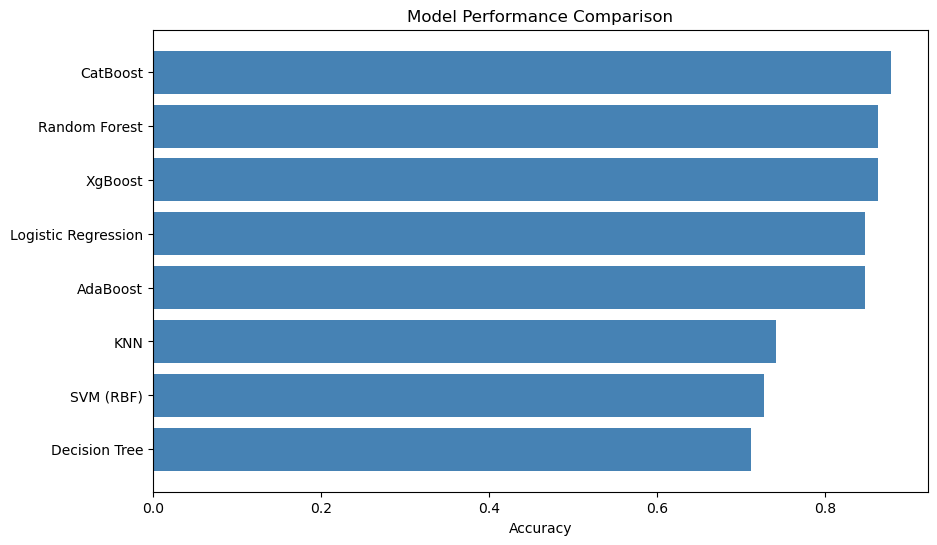

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(results_df["Model"], results_df["Accuracy"], color='steelblue')
plt.xlabel("Accuracy")
plt.title("Model Performance Comparison")
plt.gca().invert_yaxis()
plt.show()
